In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(batchelor)
    library(patchwork)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [2]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")
log_info("SCE object done")


In [3]:
sce <- sce_complete[, sce_complete$leiden_global_celltype %in% c("CD14+ Monocytes", "CD1c+ Dendritic Cell", "CD16+ Monocytes",
                                                                 "CLEC9A+/LAMP3+ Dendritic Cell", "Mast Cell",
                                                                 "Macrophage")]
sce <- logNormCounts(sce)

In [4]:
table(sce_complete$leiden_global_celltype)


                        B Cell                 Blood CD16+ NK 
                           657                            507 
               CD14+ Monocytes                      CD16- NK  
                           370                            309 
               CD16+ Monocytes           CD1c+ Dendritic Cell 
                           198                            318 
 CLEC9A+/LAMP3+ Dendritic Cell                    Endothelial 
                           118                           1189 
                   Hepatocytes                           ILCs 
                          1468                             37 
Liver bi-potent/Cholangiocytes                     Macrophage 
                           118                            579 
                     Mast Cell                     Mesenchyme 
                            58                            650 
                 Plasma B Cell             Proliferative T/NK 
                           270                        

# Feature Selection

In [5]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1, density.weights=TRUE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [6]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [7]:
mt_pca <- adata_sce$obsm['X_pca']

In [8]:
mnn_out <- reducedMNN(mt_pca, batch = sce$donor, auto.merge = TRUE, k=10, BPPARAM = MulticoreParam(workers = 12))

Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped a

In [16]:
adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_mnn" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$leiden(adata_sce, resolution = .8)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [17]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")


In [18]:
sce_old <- readRDS("../../../data/expression/sce/archive/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")
ov_cells <- intersect(colnames(sce_old), colnames(sce))
colData(sce)[ov_cells, "old_anno"] <- as.character(colData(sce_old)[ov_cells, "celltype"])

In [32]:
leiden2celltype <- c(
    '0' = 'Mac_C01-THBS1',
    '1' = 'Mono_C01-CD14',
    '2' = 'DC_C01-CD1C',
    '3' = 'Mono_C02-FCGR3A',
    '4' = 'Mac_C02-C1QA',
    '5' = 'DC_C02-CLEC9A',
    '6' = 'Mast',
    '7' = 'DC_C03-LAMP3',
    '8' = 'DC_C04-CLEC4C',
    '9' = 'DC_C05-FCER1A'
)
sce$leiden_anno <- plyr::mapvalues(x = sce$leiden, from = names(leiden2celltype), to = leiden2celltype)

In [23]:
table(sce$leiden, sce$tissue)

   
    Blood Normal Tumor TumorCore
  0     0     75   291         1
  1   329      7     5         0
  2     0    202   129         0
  3   160     33    39         0
  4     0     88    97         0
  5     1     50    32         0
  6     2      6    51         0
  7     0      5    14         0
  8     3      7     4         0
  9    10      0     0         0

In [21]:
table(sce$old_anno, sce$leiden)

                  
                     0   1   2   3   4   5   6   7   8   9
  CD4-C5-TCF7        0   0   0   0   0   0   4   0   0   0
  CD4/CD8-C2-MKI67   0   0   0   0   0   0   1   0   0   0
  DC-C1-CD1C         2   0 254   0  11   0   0   0   0   0
  DC-C2-FCER1A       5   1   9   0   1   0   0   0   0  10
  DC-C3-CLEC9A       0   0   0   0   0  83   0   0   0   0
  DC-C4-LAMP3        0   0   1   0   0   0   0  17   0   0
  ILCs               0   0   0   0   0   0   0   0  13   0
  Mast-C2-CPA3       0   0   0   0   0   0  48   0   0   0
  Mono-C1-CD14       0 292   0   0   1   0   0   0   0   0
  Mono-C2-FCGR3A     1   2   0 227   5   0   0   0   0   0
  Mphi-C1-THBS1     10   1   0   0 145   0   0   0   0   0
  Mphi-C2-C1QA     325   0  67   2  20   0   0   0   0   0
  Mphi-C5-VCAN       3  45   0   2   2   0   0   0   0   0
  Mphi-C6-MARCO      5   0   0   1   0   0   0   0   0   0
  NA                16   0   0   0   0   0   6   2   1   0

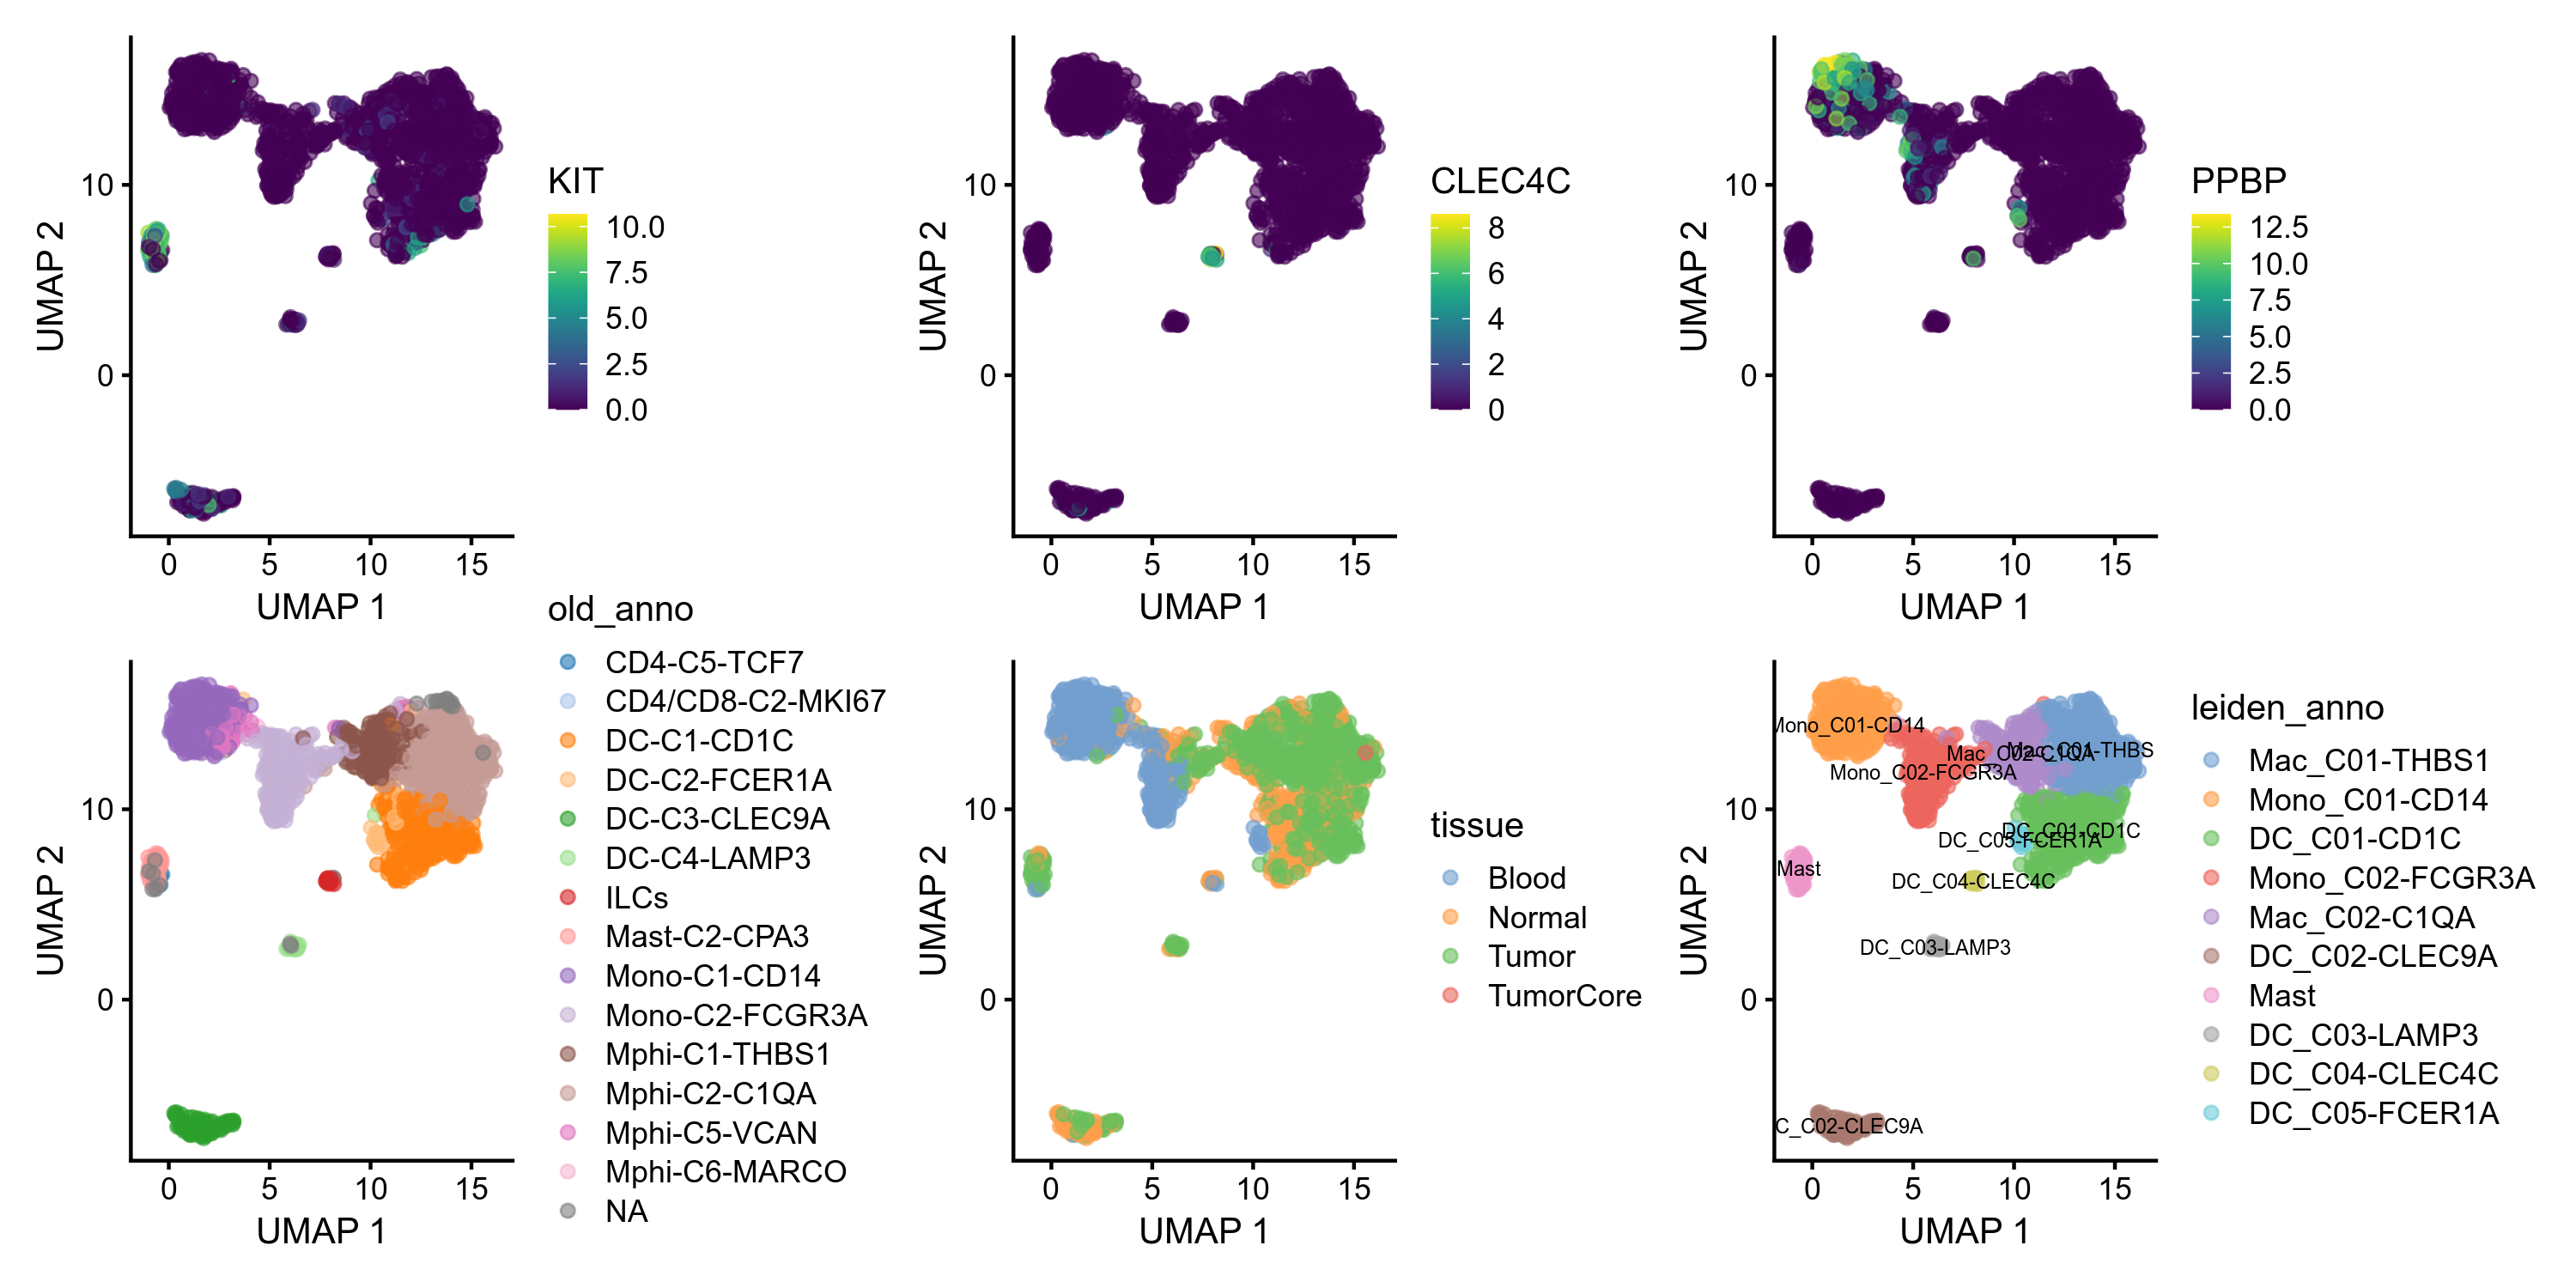

In [33]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'KIT')
p2 <- plotUMAP(sce, colour_by = 'CLEC4C')
p3 <- plotUMAP(sce, colour_by = 'PPBP')
p4 <- plotUMAP(sce, colour_by = 'old_anno')
p5 <- plotUMAP(sce, colour_by = 'tissue')
p6 <- plotUMAP(sce, colour_by = 'leiden_anno', text_by = 'leiden_anno', text_size = 2)


p1 + p2 + p3 + p4 + p5 + p6

In [34]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, groups = sce$leiden_anno, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [35]:
openxlsx::write.xlsx(top_markers, "./output/TopMarkers_myeloid.xlsx")

# Do not annotate it

In [36]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_Myeloid.rds")